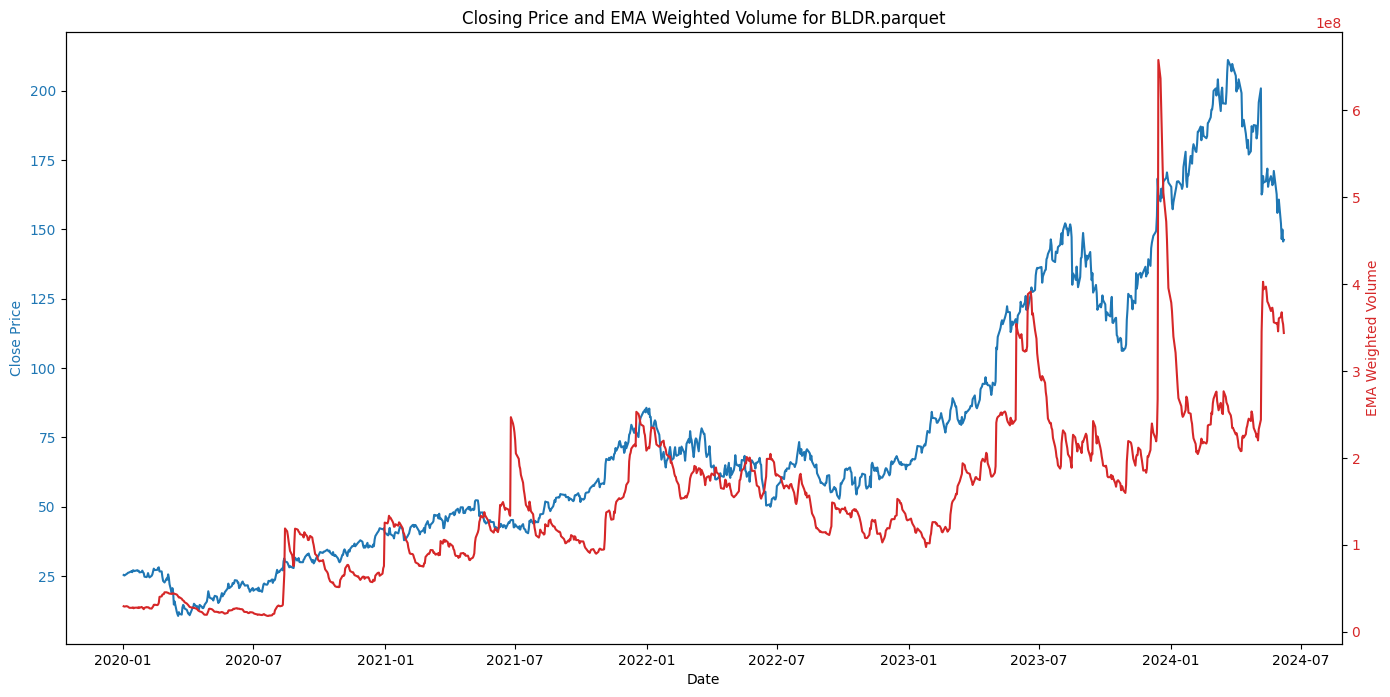

In [187]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import random

def load_all_files(data_directory):
    files = [file for file in os.listdir(data_directory) if file.endswith('.parquet')]
    return files

def load_file(file_path):
    try:
        df = pd.read_parquet(file_path)
        df.index = pd.to_datetime(df.index)
        df = df.sort_index()
        return df
    except Exception as e:
        print(f"Error loading file {file_path}: {e}")
        return None

def calculate_weighted_volume_ema(df, ema_span=20):
    """
    Calculate the EMA of the closing price-weighted volume.

    Parameters:
    df (pd.DataFrame): DataFrame containing OHLCV data with 'Close' and 'Volume' columns.
    ema_span (int): Span for calculating the EMA of the weighted volume.

    Returns:
    pd.Series: EMA of the weighted volume.
    """
    df['Weighted_Volume'] = df['Close'] * df['Volume']
    df['Weighted_Volume_EMA'] = df['Weighted_Volume'].ewm(span=ema_span, adjust=False).mean()
    
    return df

def main(data_directory):
    files = load_all_files(data_directory)
    if not files:
        print("No parquet files found in the directory.")
        return
    
    random_file = random.choice(files)
    file_path = os.path.join(data_directory, random_file)
    df = load_file(file_path)
    
    if df is not None and 'Close' in df.columns and 'Volume' in df.columns:
        df = calculate_weighted_volume_ema(df)
        
        fig, ax1 = plt.subplots(figsize=(14, 7))
        
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Close Price', color='tab:blue')
        ax1.plot(df.index, df['Close'], color='tab:blue', label='Close Price')
        ax1.tick_params(axis='y', labelcolor='tab:blue')

        ax2 = ax1.twinx()
        ax2.set_ylabel('EMA Weighted Volume', color='tab:red')
        ax2.plot(df.index, df['Weighted_Volume_EMA'], color='tab:red', label='EMA Weighted Volume')
        ax2.tick_params(axis='y', labelcolor='tab:red')

        fig.tight_layout()
        plt.title(f'Closing Price and EMA Weighted Volume for {random_file}')
        plt.show()
    else:
        print(f"Failed to load data or required columns not found in {random_file}.")

if __name__ == "__main__":
    data_directory = 'Data/PriceData'
    main(data_directory)
